# TCGA - COAD ML

In [4]:
# import libs
#import libs
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from matplotlib import cm
# PCA Analyis
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from IPython.display import Image
# ML 
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
# Deep Learning
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
# Other
import warnings
warnings.filterwarnings('ignore')

Read in data to using pandas. Has to be transformed to be used downstream (transposed)

In [2]:
# Load in Data + Trnasform Direction
df=pd.read_csv('COAD_normalized_counts.csv') # load
df=df.transpose()

genes=df.loc['new_gene'].to_list() # saves all genes as list
df.columns=genes

samples=df.index.to_list()
samples=samples[1:] # removes the "New_Gene" Label

df=df.drop(['new_gene']).reset_index(drop=True) # remove gene column 
df.index=samples # set index names 

df=df.astype(float) # weird nonsense step thats needed ~sometimes~
df.head() # show results

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RPS3P6,GSTM2,ST13P11,RANP6,NAP1L1P3,LINC00671,GAPDHP71,COG8,EIF4E2P1,ARHGAP19
TCGA.A6.5665_Tumor1,6730.462949,27.512452,1557.204808,811.617347,190.753004,213.680047,2604.512164,3091.482573,1705.772051,1042.721947,...,0.000000,367.7498,0.000000,0.917082,2.751245,4.585409,0.000000,851.9689,0.0000,464.0434
TCGA.AA.3662_Healthy,6785.922984,20.711522,2561.601009,957.700765,510.331896,207.943678,1122.564478,4752.880009,2023.101444,1378.558887,...,1.656922,177.2906,0.828461,1.656922,3.313843,0.828461,43.908430,932.8469,0.0000,357.8951
TCGA.A6.2684_Healthy,3596.940007,51.044560,1121.846000,722.564107,210.984182,425.371335,2409.303240,2755.271926,2166.557998,1134.323559,...,2.268647,781.5489,0.000000,0.000000,3.402971,15.880530,1.134324,1037.9060,0.0000,535.4007
TCGA.A6.5659_Tumor1,25713.506410,102.205104,3165.113628,987.982675,1017.184134,74.625949,608.363716,1966.231531,5022.650843,3264.074126,...,0.000000,168.7195,0.000000,0.000000,21.089940,6.489213,0.000000,1495.7640,595.3853,666.7666
TCGA.AA.3511_Healthy,5526.721541,37.276747,4557.526115,460.634090,259.162147,551.163333,2647.536592,3907.845664,2214.416291,1257.646447,...,5.325250,235.1985,0.887542,0.887542,3.550166,2.662625,11.538040,1026.8860,0.0000,439.3331


### pre-processing step  to remove genes that have low expression
Removing genes when not expressed in at least 20 samples


In [3]:
# Pre-Process: Filter out low expressed genes
count=0; # keep track of how many genese removed

thresh=35 # min number of samples needed
for col in df.columns.to_list():
    n_zeros=df[col].isin([0]).sum()
    
    if n_zeros >= thresh:
        count+=1
        df.drop([col],axis=1,inplace=True)

print("Removed %d genes. These genes did not meet 20 sample mininum. \nWe have %d genes left \
"%(count,len(df.columns.to_list())))

Removed 3642 genes. These genes did not meet 20 sample mininum. 
We have 17441 genes left 


### Using Gene Signature

In [8]:
df_gene_sig=df[['TREML2', 'PTPRN', 'PGLYRP1', 'NOG', 'VIP',\
    'RIMKLB', 'NKAIN4', 'FAM171B', 'ZNF417', 'GLRA2', 'HOXA7', 'FABP6', 'MUSK',\
    'HTR6', 'GRIP2', 'VEGFA', 'AKAP12', 'RHEB', 'PMEPA1','GLTP', 'METTL7A',\
    'CITED2', 'SCARA5', 'CDH3','IL6R', 'PKIB', 'GLP2R', 'EPB41L3', 'NR3C2']]

# Genes not found from gene signature (possible namin g issues)
# PADI4, NCKIPSD C5orf53 TREML3 HES5 OR8D2 KLRK1 NCRNA00152 PPAP2A LINC00974

df_gene_sig.head(10)

,TREML2,PTPRN,PGLYRP1,NOG,VIP,RIMKLB,NKAIN4,FAM171B,ZNF417,GLRA2,...,GLTP,METTL7A,CITED2,SCARA5,CDH3,IL6R,PKIB,GLP2R,EPB41L3,NR3C2
TCGA.A6.5665_Tumor1,34.849106,131.142690,0.000000,4.585409,1583.800179,485.13620,14.673308,180.665104,172.4114,132.976854,...,5113.647827,10807.8100,3998.476,3048.38000,36.683270,2065.2680,4870.621164,463.126283,2127.629655,3683.000300
TCGA.AA.3662_Healthy,21.539983,46.393809,1.656922,5.799226,471.394235,149.12300,16.569217,124.269131,138.3530,159.892948,...,2163.111331,1163.1590,1068.715,352.09590,6367.550244,920.4200,265.935939,62.134565,485.478070,840.887783
TCGA.A6.2684_Healthy,34.029707,364.117863,11.343236,18.149180,2108.707497,621.60930,15.880530,311.938979,175.8202,21.552148,...,4020.042694,10622.9400,4611.025,6950.00000,35.164030,3370.0750,5085.172517,360.714892,4387.563528,4114.191550
TCGA.A6.5659_Tumor1,1.622303,16.223032,30.823762,12.978430,120.050440,624.58670,1.622303,303.370707,3867.5710,1124.256148,...,1205.371310,1893.2280,1531.454,176.83110,1361.112421,173.5864,152.496505,11.356123,446.133392,700.835001
TCGA.AA.3511_Healthy,7.100333,86.091535,1.775083,6.212791,463.296715,339.04090,31.063956,332.828100,149.9945,28.401331,...,1963.242019,2951.9630,1073.925,310.63960,4282.388219,564.4765,447.320966,26.626248,924.818347,774.823817
TCGA.AZ.6600_Healthy,14.753228,406.281200,7.944046,19.292680,4398.731648,1063.36700,17.022955,371.100425,179.3085,77.170731,...,3675.823480,7874.8190,3577.090,6772.86600,47.664275,3179.8880,4001.529358,425.573882,3838.108987,4160.410274
TCGA.A6.5667_Tumor,23.839089,45.123990,4.256980,2.554188,148.994305,95.35636,22.987693,134.520573,246.9048,85.990999,...,2238.320160,671.7515,5193.516,142.18310,6429.742811,476.7818,1296.676152,32.353049,504.877845,467.416420
TCGA.A6.2685_Tumor,29.195209,342.001014,11.469546,9.384174,4548.196413,798.69750,89.670998,405.604861,135.5492,45.878185,...,3818.316200,6479.2510,3597.267,1730.85900,211.665262,2377.3240,3931.968976,598.501775,2690.129928,2878.856097
TCGA.A6.2684_Tumor1,8.229663,1.175666,4.702665,58.783310,16.459326,45.85098,0.000000,139.904272,111.6883,0.000000,...,2125.604406,784.1693,2454.791,55.25631,3956.116608,158.7149,536.103766,12.932328,211.619908,367.983506
TCGA.AA.3655_Healthy,20.797749,436.752724,18.817011,3.961476,1400.381750,1272.62400,21.788118,309.985494,216.8908,15.845904,...,2634.381510,9148.0380,3631.683,4238.77900,543.712575,2533.3640,942.831277,527.866671,3876.304222,2557.132729


### Log Transform 

## Extract Tissue sample from columns (healthy or tumor)
and then stick that into a panda series (single column dataframe). This is out "Y" while the df1 which contains all the genes is our "X".

We can do this since the "X" and "y" align via index. 

E.g 3rd row in df1 (TCGA.A6.2684_Healthy) has target  of "healthy" in Y!

In [5]:
# Create Target vector
target=[]
sample_names=[]

# loop through and extract tumor + healthy
for i in samples:
    
    temp=i.split('_')[1] # Split string using "_"
    #remove numbers at end (if they have it)
    if temp[-1].isnumeric():
        temp=temp[:-1]
    
    target.append(temp)# save tissues type to list (in order)

        
# Convert to Panda Series
target=pd.Series(target,name='Tissue')

In [6]:
# Convert to binary tumor(1) + healthy(0)
target_binary=[]
for i in target:
    if i=='Healthy':
        target_binary.append(0)
    else:
        target_binary.append(1)
        
# Convert to Panda Series
target_binary=pd.Series(target_binary)

# Visualize Data
just resuing old code, not really optimized tbh

Text(0, 0.5, 'Component 2')

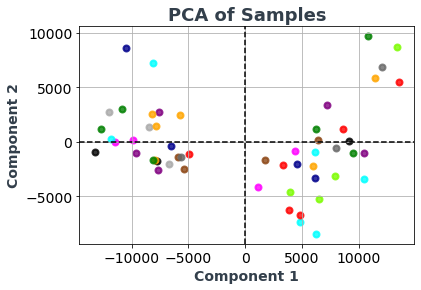

In [9]:
# Generate Colors + numbers
colors=['black','dimgrey','darkgrey',\
       'green','green','cyan','cyan','red','red','orange','orange'\
       ,'purple','purple','lawngreen','lawngreen','darkblue','darkblue'\
       ,'magenta','magenta','saddlebrown','saddlebrown','black','dimgrey','darkgrey',\
       'green','green','cyan','cyan','red','red','orange','orange'\
       ,'purple','purple','lawngreen','lawngreen','darkblue','darkblue'\
       ,'magenta','magenta','saddlebrown','saddlebrown','black','dimgrey','darkgrey',\
       'green','green','cyan','cyan','red','red','orange','orange'\
       ,'purple','purple','lawngreen','lawngreen','darkblue','darkblue'\
       ,'magenta','magenta','saddlebrown','saddlebrown']

num_list=range(0,54)

# PCA 
pca = PCA(n_components=2)
X_r = pca.fit(df_gene_sig).transform(df_gene_sig)
# Plot

for color, i, target_name in zip(colors, num_list, samples):
    plt.scatter(X_r[i,0], X_r[i,1], color=color, alpha=.8, lw=2,
                label=target_name)
    
    
plt.title('PCA of Samples', fontsize=18, fontweight='black', color = '#333F4B')
plt.axvline(x=0,linestyle='--',c='k')
plt.axhline(y=0,linestyle='--',c='k')
plt.tick_params(axis='y', which='major', labelsize=14)
plt.tick_params(axis='x', which='major', labelsize=14)
plt.grid(True)
plt.xlabel('Component 1', fontsize=14, fontweight='black', color = '#333F4B')
plt.ylabel('Component 2', fontsize=14, fontweight='black', color = '#333F4B')

RIP to clustering with PCA haha

In [6]:
# Other Visuals 


## Split Data - K Folds Cross Validation

In [10]:
print(np.shape(df))
print(np.shape(target_binary))
print(np.shape(df_gene_sig))

(55, 17441)
(55,)
(55, 29)


(rows=patients,genes=columns)

### Split into testing and training data first

In [11]:
# Split Into Training and Test Data
x_train, x_test, y_train, y_test = train_test_split(df_gene_sig, target_binary, test_size=15,shuffle=True, random_state=12)
# display size of 
print('Our Training Data Set has %d patient samples'%(np.shape(x_train)[0]))
print('Our Testing Data Set has %d patient samples'%(np.shape(x_test)[0]))

Our Training Data Set has 40 patient samples
Our Testing Data Set has 15 patient samples


### Split traing Data further into K- Folds

In [12]:
# Cross Fold Validation - Create 3 sets (from traing data)
kf = KFold(n_splits = 4)                      
skf = StratifiedKFold(n_splits = 4, random_state = 12, shuffle = True) # Generates indicies

# This code would be used in the ML algorithm
# Show Each Fold (indicies)
for train_index, test_index in skf.split(x_train, y_train):
    
    # Insert ML code here
    #
    # Example code on how to get data from indicies
    # x_train.iloc[train_index]
    #
    
    print("TRAIN:", train_index, "\nTEST:", test_index,'\n') # used to show indexes
    #print(y_train.iloc[train_index].value_counts())

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 25 27 28 30
 32 34 35 36 37 39] 
TEST: [19 21 22 23 24 26 29 31 33 38] 

TRAIN: [ 5  6  7  8  9 10 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 31
 32 33 35 37 38 39] 
TEST: [ 0  1  2  3  4 11 20 30 34 36] 

TRAIN: [ 0  1  2  3  4  6  7  9 10 11 13 16 19 20 21 22 23 24 25 26 28 29 30 31
 32 33 34 35 36 38] 
TEST: [ 5  8 12 14 15 17 18 27 37 39] 

TRAIN: [ 0  1  2  3  4  5  8 11 12 14 15 17 18 19 20 21 22 23 24 26 27 29 30 31
 33 34 36 37 38 39] 
TEST: [ 6  7  9 10 13 16 25 28 32 35] 



# Deep Learning

### ~Notebook~

**Diff Models**
* 10-5-2-1 produces C.M=[0,5;0,10] , this is pretty good at predicting cancer, but not at predicting healthy haha

* 12-2-4-2-1 produces C.M=[4,1;1,9], super good, much wow

In [39]:
# Creating Model
# input = 21083 nodes (all genes... for now)
# hidden nodes = 125 (basic for now)
# output = 2 nodes

# define baseline model
# create model
def baseline_model_big():
   # create model
    model = Sequential()
    model.add(Dense(8, input_dim=21083, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [13]:
# Creating Model
# input = 21083 nodes (all genes... for now)
# hidden nodes = 125 (basic for now)
# output = 2 nodes

# define baseline model
# create model
def baseline_model():
   # create model
    model = Sequential()
    model.add(Dense(8, input_dim=29, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model


Fold Number: 1
[[15  4]
 [12  9]]
Accuracy: 0.5333
AUC: 0.6090

Fold Number: 2
[[14  5]
 [ 6 15]]
Accuracy: 0.6444
AUC: 0.7256

Fold Number: 3
[[18  1]
 [14  7]]
Accuracy: 0.5556
AUC: 0.6404

Fold Number: 4
[[ 4 15]
 [ 0 21]]
Accuracy: 0.5556
AUC: 0.6053

Test Data:
[[0 5]
 [2 8]]
Accuracy: 0.5333
AUC: 0.4000


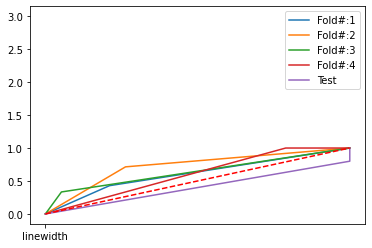

In [19]:
# Using K-Fold
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=10, verbose=0)

c=1
for train_index, test_index in skf.split(x_train, y_train):
    print('\nFold Number: %d'%(c))
    X=x_train.iloc[train_index]
    Y=y_train.iloc[train_index]
    estimator.fit(X, Y)
    results=estimator.predict(x_train)
    
    cm=confusion_matrix(y_train, results)
    # ROC 
    fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_train, results)
    auc_k = auc(fpr_kera, tpr_kera)
    lab='Fold#:'+str(c)
    plt.plot(fpr_kera, tpr_kera, label=lab)
    
    print(cm)
    print('Accuracy:',round((cm[1,1]+cm[0,0])/45,4))
    print('AUC: %.4f'%(auc_k))
    c+=1

# Test Set
print('\nTest Data:')

# run it foward
results=estimator.predict(x_test)
cm=confusion_matrix(y_test, results)
# ROC 
fpr_kera, tpr_kera, thresholds_rf = roc_curve(y_test, results)
auc_k = auc(fpr_kera, tpr_kera)
lab='Test'
plt.plot(fpr_kera, tpr_kera, label=lab)

# show results
print(cm)
print('Accuracy:',round((cm[1,1]+cm[0,0])/15,4))
print('AUC: %.4f'%(auc_k))

# plot 
plt.legend()
plt.plot([0, 1], [0, 1],'r--',inewidth=7.0)

In [59]:
# not using K-Fold
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=1, verbose=0)
estimator.fit(x_train, y_train)
results=estimator.predict(x_test)
cm=confusion_matrix(y_test, results)
print(cm)
print('Accuracy:',round((cm[1,1]+cm[0,0])/15,4))

[[ 0  5]
 [ 0 10]]
Accuracy: 0.6667


### Saving Models

In [135]:
estimator.model.get_weights()[1:]
#estimator.model.summary()
#set_weights(weights)

[array([ 0.        ,  0.        ,  0.03681539, -0.05669684,  0.        ,
        -0.04651759,  0.0020434 , -0.01200365, -0.00210685, -0.0244621 ,
        -0.02249151, -0.01963987], dtype=float32),
 array([[-0.21253973, -0.3968487 ],
        [-0.54334456,  0.2334798 ],
        [-0.13222323, -0.36945477],
        [ 0.19033076,  0.05234013],
        [ 0.16450155,  0.2533245 ],
        [ 0.08814546,  0.01912271],
        [-0.47809952,  0.2614989 ],
        [-0.49174315,  0.19429055],
        [ 0.56239027, -0.5361324 ],
        [ 0.39826876,  0.17065966],
        [ 0.00707114,  0.31649172],
        [ 0.4783114 , -0.00407529]], dtype=float32),
 array([-0.05611094, -0.03367838], dtype=float32),
 array([[ 0.07846164,  0.39712062, -0.7310612 , -0.60754836, -0.7141605 ,
         -0.20583147,  0.7231539 ,  0.07313287],
        [-0.33394822, -0.184321  , -0.17567003, -0.35212952,  0.2058786 ,
         -0.74182165, -0.3299632 ,  0.5457847 ]], dtype=float32),
 array([ 0.17226347,  0.1811136 ,  0.   

In [104]:

save_weights=estimator.model.get_weights()